In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Augmentation

In [2]:

# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# flip vertically
        validation_split=0.2) 

# Import the Data

In [3]:
train=datagen.flow_from_directory(  "../input/weather-dataset/dataset",  
                                    target_size=(224, 224), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset="training"
)
validation=datagen.flow_from_directory(  "../input/weather-dataset/dataset",  
                                    target_size=(224, 224), 
                                    shuffle=True,
                                    seed=42,
                                    color_mode='rgb', 
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset='validation'
)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [4]:
class_names = list(train.class_indices.keys())
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

# Download the pretrained model

In [5]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Adding new layers + freezing layers

In [7]:
base_model.trainable = False#freezing
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(11, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile the model

In [8]:
 model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Callbacks

In [9]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

# Fit the model

In [10]:
history = model.fit(
    train,
    validation_data=validation,
    epochs=5,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/5
172/172 [==============================] - 164s 872ms/step - loss: 2.0454 - accuracy: 0.5245 - val_loss: 1.0846 - val_accuracy: 0.7005
Epoch 2/5
172/172 [==============================] - 104s 605ms/step - loss: 0.9093 - accuracy: 0.7364 - val_loss: 0.8443 - val_accuracy: 0.7714
Epoch 3/5
172/172 [==============================] - 103s 598ms/step - loss: 0.7131 - accuracy: 0.7855 - val_loss: 0.7299 - val_accuracy: 0.7867
Epoch 4/5
172/172 [==============================] - 105s 609ms/step - loss: 0.5973 - accuracy: 0.8132 - val_loss: 0.7810 - val_accuracy: 0.7867
Epoch 5/5
172/172 [==============================] - 104s 605ms/step - loss: 0.5500 - accuracy: 0.8267 - val_loss: 0.6252 - val_accuracy: 0.8188


# Fine Tuning the model

In [11]:
# Unfreeze the base model
base_model.trainable = True
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(11, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              )

In [12]:
history = model.fit(
    train,
    validation_data=validation,
    epochs=5,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/5
172/172 [==============================] - 133s 720ms/step - loss: 1.1604 - accuracy: 0.6348 - val_loss: 0.6703 - val_accuracy: 0.7728
Epoch 2/5
172/172 [==============================] - 122s 710ms/step - loss: 0.5566 - accuracy: 0.8127 - val_loss: 0.5570 - val_accuracy: 0.8174
Epoch 3/5
172/172 [==============================] - 119s 692ms/step - loss: 0.4370 - accuracy: 0.8538 - val_loss: 0.4740 - val_accuracy: 0.8313
Epoch 4/5
172/172 [==============================] - 120s 698ms/step - loss: 0.3576 - accuracy: 0.8809 - val_loss: 0.4485 - val_accuracy: 0.8524
Epoch 5/5
172/172 [==============================] - 121s 702ms/step - loss: 0.3029 - accuracy: 0.8924 - val_loss: 0.4569 - val_accuracy: 0.8583


# Predictions 

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

In [14]:
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

1/1 [==============================] - 1s 968ms/step


'dew'

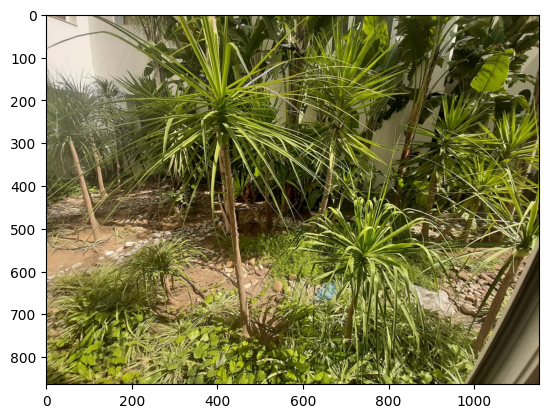

In [15]:
class_names[np.argmax(make_predictions("/kaggle/input/image1/image1.jpg"))]

1/1 [==============================] - 0s 22ms/step


'rainbow'

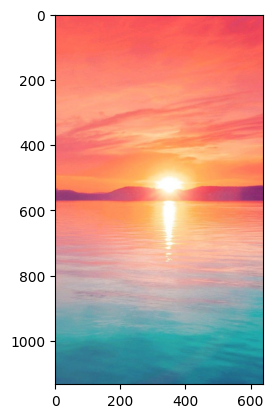

In [16]:
class_names[np.argmax(make_predictions("/kaggle/input/sunny/sun.jpg"))]

1/1 [==============================] - 0s 24ms/step


'snow'

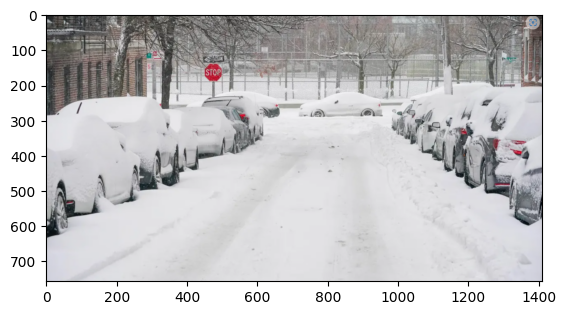

In [17]:
class_names[np.argmax(make_predictions("/kaggle/input/snow-weather/snow.png"))]